In [1]:
import joblib
import click
import json
import time
import os
import itertools
import collections.abc
from shutil import copy,SameFileError
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pennylane as qml
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from qiskit_ibm_provider import IBMProvider

from quantum.Quantum import QuantumRegressor
from quantum.Evaluate import evaluate
from settings import ANSATZ_LIST, ENCODER_LIST
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import InconsistentVersionWarning

/var/folders/px/qyhp9b8j4bb0z5wgydzgkpxw0000gn/T/ipykernel_55528/1996331647.py:17: DeprecationWarning: The package qiskit_ibm_provider is being deprecated. Please see https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime to get instructions on how to migrate to qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  from qiskit_ibm_provider import IBMProvider


In [63]:
num_qubits=16
LAYERS=1
re_upload_depth=1
# device='qiskit.aer'
# device_backend = FakeCairoV2()
# backend = AerSimulator.from_backend(device_backend)
# device = qml.device(device, wires=num_qubits, backend=backend, shots=shots)


device='qulacs.simulator'
device = qml.device(device, wires=num_qubits)

In [64]:
encoder=ENCODER_LIST['IQP']

In [65]:
variational=ANSATZ_LIST['Full-Pauli-CRZ']
variational.set_wires(range(num_qubits))
variational.layers = LAYERS


num_params = variational.num_params * re_upload_depth
generator = np.random.default_rng(12958234)
initial_parameters = generator.uniform(-np.pi, np.pi, num_params)


In [66]:
def circuit(features, parameters):
    #  builds the circuit with the given encoder and variational circuits.
    #  encoder and variational circuits must have only two required parameters, params/feats and wires
    for i in range(re_upload_depth):
        params = initial_parameters.reshape(re_upload_depth,-1)[i]
        
        encoder(features, wires=range(num_qubits))
        variational(params, wires=range(num_qubits))

    return qml.expval(qml.PauliZ(0))


In [67]:
qnode = qml.QNode(circuit, device)

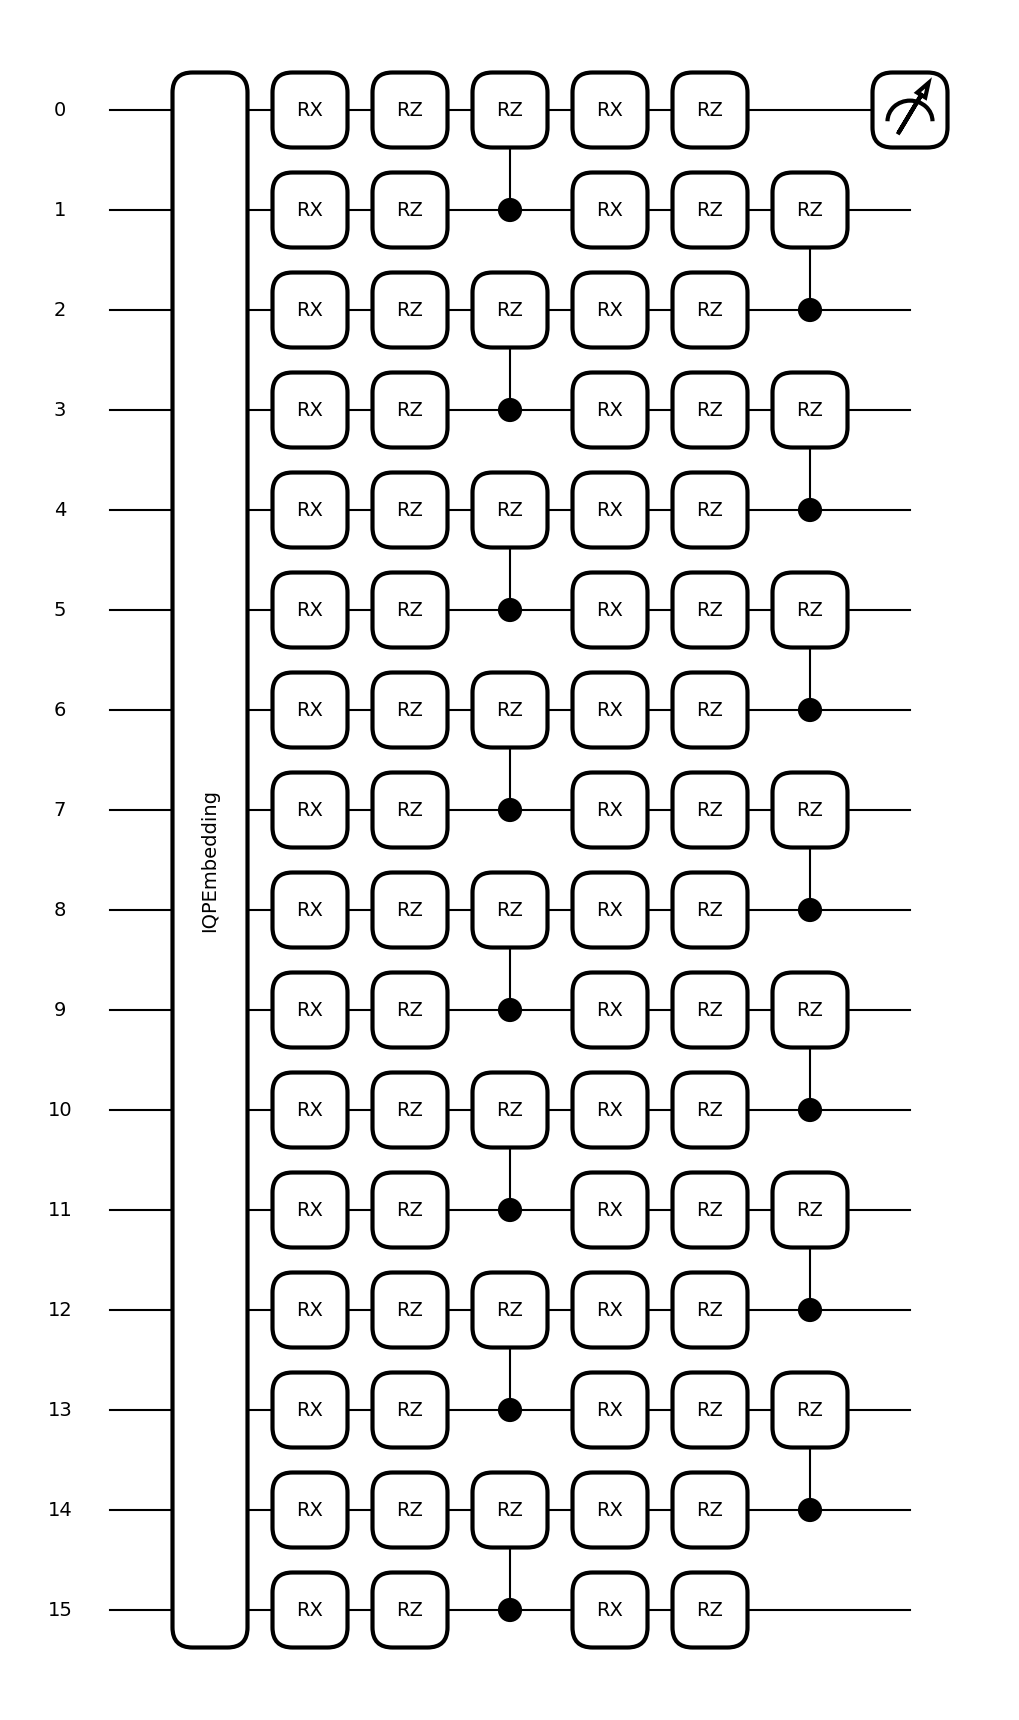

In [74]:
qml.draw_mpl(qnode,level=2)(np.arange(16),initial_parameters)
plt.show()

In [69]:
initial_parameters.size//5

15

In [70]:
circuit_specs=qml.specs(qnode)(np.arange(16),initial_parameters)

/Users/grierjones/miniconda3/envs/simple_qml/lib/python3.12/site-packages/pennylane/gradients/gradient_transform.py:261: UserWarning: Attempted to compute the gradient of a tape with no trainable parameters. If this is unintended, please mark trainable parameters in accordance with the chosen auto differentiation framework, or via the 'tape.trainable_params' property.
  warnings.warn(_no_trainable_grad_warning)


In [71]:
circuit_specs['resources']

wires: 16
gates: 80
depth: 7
shots: Shots(total=None)
gate_types:
{'IQPEmbedding': 1, 'RX': 32, 'RZ': 32, 'CRZ': 15}
gate_sizes:
{16: 1, 1: 64, 2: 15}


(<Figure size 2300x500 with 1 Axes>, <Axes: >)

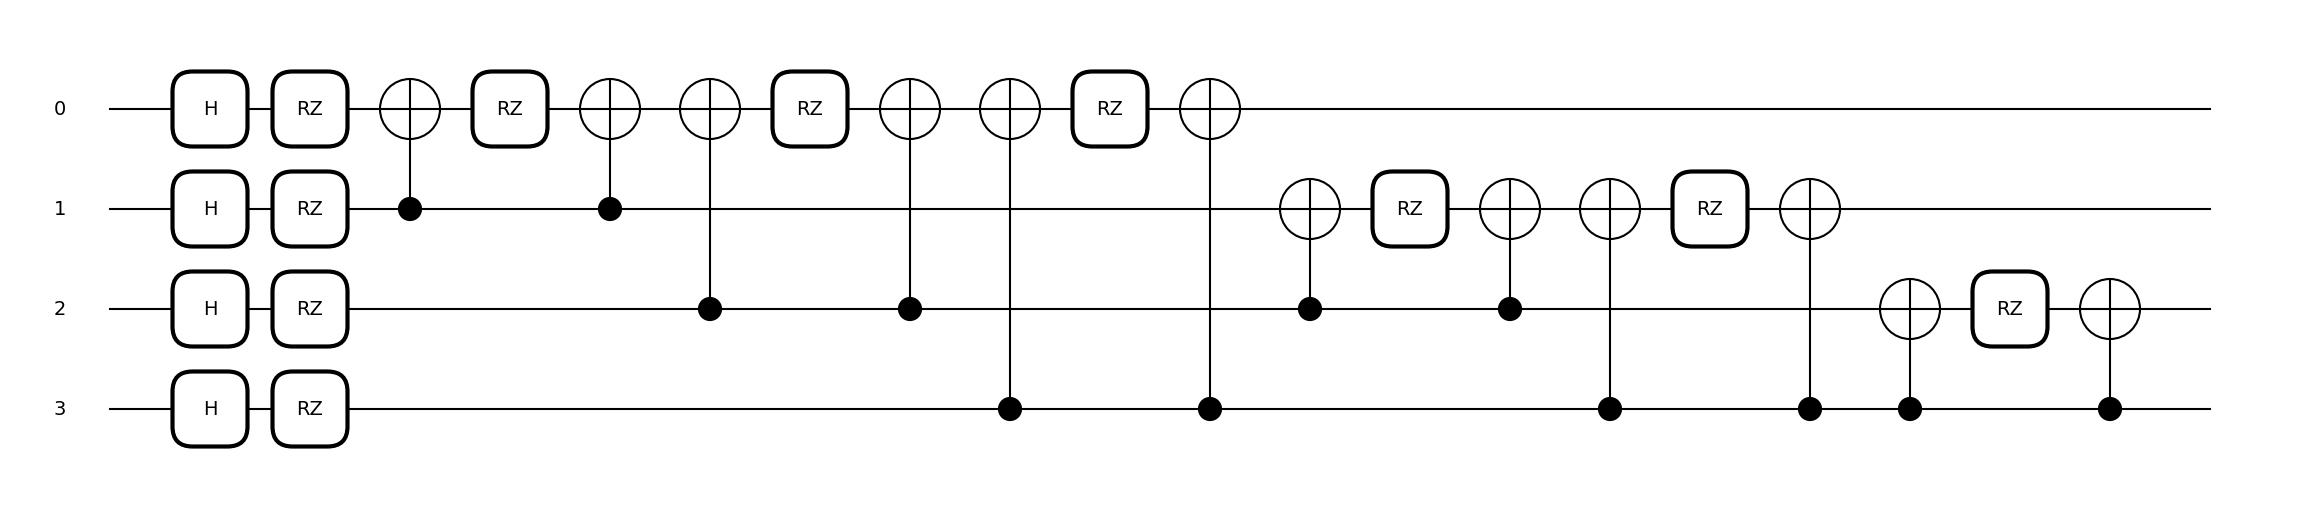

In [94]:
qml.draw_mpl(qml.QNode(encoder, device),expansion_strategy='device')(np.arange(4), wires=range(4))

(<Figure size 2300x500 with 1 Axes>, <Axes: >)

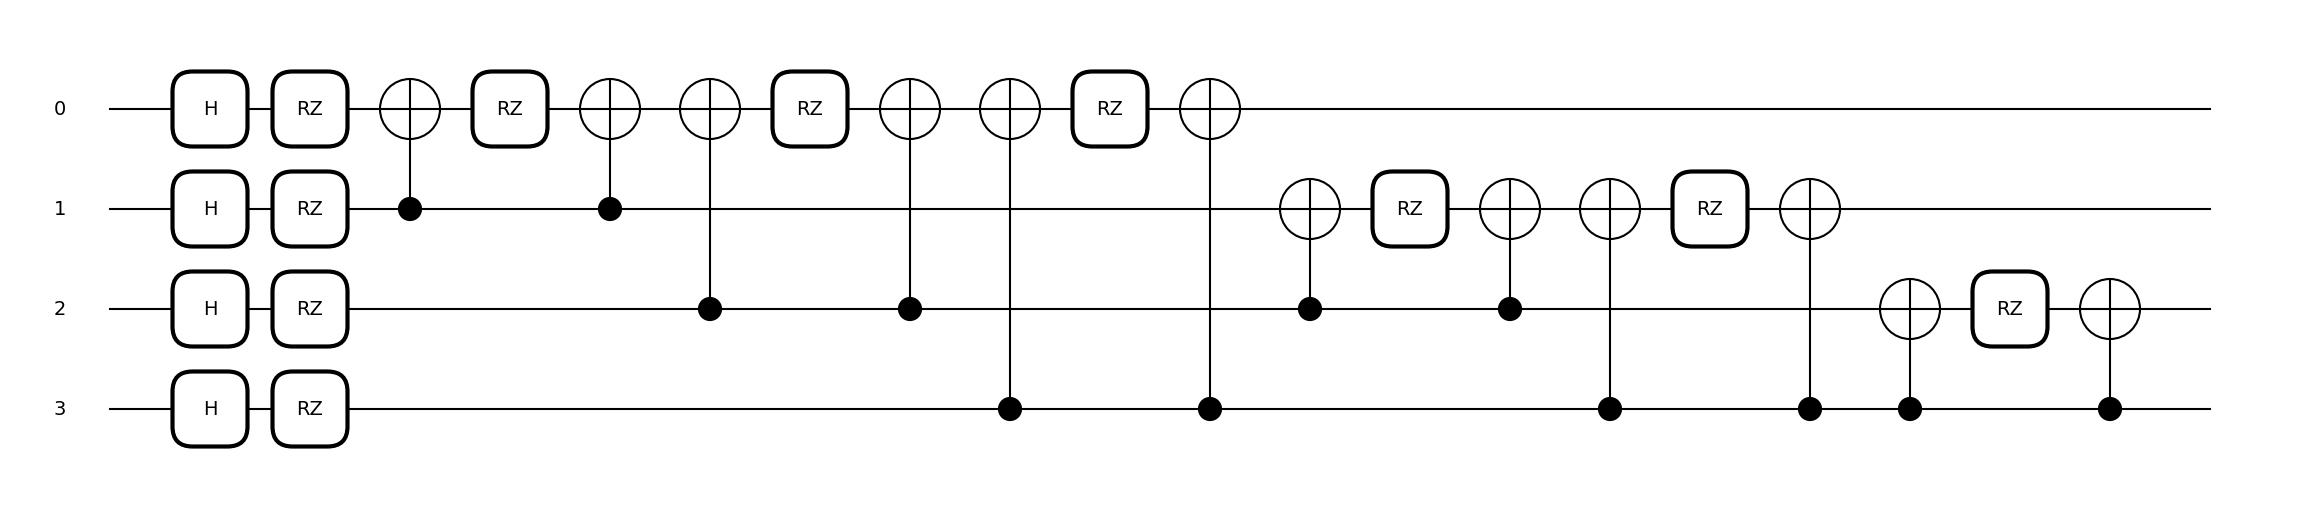

In [93]:
qml.draw_mpl(qml.QNode(qml.IQPEmbedding,device,expansion_strategy='device'))(np.arange(4), wires=range(4))